In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from PIL import Image
import glob
from IPython.display import display, clear_output
from pynq import Clocks, Overlay, allocate

In [2]:
INPUT_WIDTH = 256
INPUT_HEIGHT = 256
CHANNELS = 3
OUTPUT_WIDTH = 16
WEIGHTS_HEIGHT = 31744
WEIGHTS_WIDTH = 16

print("Loading FPGA configuration", flush=True)
overlay = Overlay("./cnn.bit")
print("FPGA configuration loaded", flush=True)

print(f"CPU  running at: {Clocks.cpu_mhz} MHZ")
print(f"FPGA running at: {Clocks.fclk0_mhz} MHZ")

dma_inputs = overlay.dma1
dma_weights = overlay.dma2

print("Allocating buffers", flush=True)
in_buffers = [
    allocate(shape=(INPUT_HEIGHT * INPUT_WIDTH * CHANNELS), dtype=np.uint8),
    allocate(shape=(INPUT_HEIGHT * INPUT_WIDTH * CHANNELS), dtype=np.uint8)
]
l3_weights_buffer = allocate(shape=(WEIGHTS_HEIGHT * WEIGHTS_WIDTH), dtype=np.int8)
out_buffer = allocate(shape=(OUTPUT_WIDTH * 8), dtype=np.int32)
print("Buffers allocated", flush=True)

in_ping_pong = False

print("Loading weights", flush=True)
l4_weights = np.load("l4_weights.npy")
l3_weights_buffer[:] = np.load("l3_weights.npy").flatten()
print("Weights loaded", flush=True)

outputs = np.zeros((OUTPUT_WIDTH))

start = time.time()
in_buffers[in_ping_pong][:] = 0

cats = glob.glob("./datasets/cats_and_dogs_256x256/train/cat/*.jpg")
cats = list(zip(cats, ["CAT"] * len(cats)))

dogs = glob.glob("./datasets/cats_and_dogs_256x256/train/dog/*.jpg")
dogs = list(zip(dogs, ["DOG"] * len(dogs)))

images = cats + dogs
np.random.shuffle(images)

print("Initiating transfer with empty buffer", flush=True)
dma_inputs.sendchannel.transfer(in_buffers[in_ping_pong])
dma_weights.sendchannel.transfer(l3_weights_buffer)

Loading FPGA configuration


FPGA configuration loaded
CPU  running at: 650.0 MHZ
FPGA running at: 83.333333 MHZ
Allocating buffers
Buffers allocated
Loading weights
Weights loaded
Initiating transfer with empty buffer


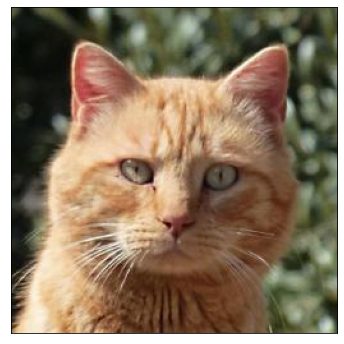

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
MAX_ITERATIONS = 40
accuracy = 0
start = time.time()
for (sample, expected_class), i in zip(images, range(MAX_ITERATIONS)):
    sample = np.array(Image.open(sample))
    ax.clear()
    ax.imshow(sample * (1/255))
    ax.set_yticks([])
    ax.set_xticks([])
    clear_output(wait=True)
    display(fig)
    counter = 0
    start = time.time()
    while start + 2 > time.time():
        in_ping_pong = not in_ping_pong
        dma_inputs.recvchannel.transfer(out_buffer)
        
        in_buffers[in_ping_pong][:] = sample.flatten()

        dma_inputs.sendchannel.wait()
        dma_inputs.sendchannel.transfer(in_buffers[in_ping_pong])
        
        dma_weights.sendchannel.wait()
        dma_weights.sendchannel.transfer(l3_weights_buffer)

        dma_inputs.recvchannel.wait()
        outputs[:] = out_buffer[7 * OUTPUT_WIDTH : 8 * OUTPUT_WIDTH]
        prediction = np.dot(outputs.reshape((1, -1)), l4_weights)
        counter += 1

    time_taken = time.time() - start
    classified = "DOG" if prediction[0, 0] >= 0 else "CAT"
    print(f"Image {i + 1} of {MAX_ITERATIONS}")
    print(f"Classified as: {classified},\texpected: {expected_class}")
    print(f"FPS: {counter / time_taken}")
    accuracy += classified == expected_class   

clear_output(wait=True)
print(f"Accuracy: {accuracy / MAX_ITERATIONS * 100} %")

In [ ]:
dma_inputs.recvchannel.transfer(out_buffer)

time.sleep(1)
in_buffers[0].freebuffer()
in_buffers[1].freebuffer()
out_buffer.freebuffer()